In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [8]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [9]:
def create_prot_t5_model():
    """Create model for ProtT5 embedding vectors"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1280,)),
        tf.keras.layers.Dense(256),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [10]:
def print_metrics(y_true, y_pred):
    """
    Print comprehensive evaluation metrics
    
    Parameters:
    y_true: array-like of true labels
    y_pred: array-like of predicted labels
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    sensitivity = cm[1][1] / (cm[1][1] + cm[1][0])  # True Positive Rate
    specificity = cm[0][0] / (cm[0][0] + cm[0][1])  # True Negative Rate
    
    # Print results
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("Confusion Matrix:")
    print(cm)

In [ ]:
def train_and_evaluate_prot_t5_model():
    """Train and evaluate ProtT5 embedding-based model"""
    
    print("Loading ProtT5 embeddings...")
    
    # Load ProtT5 data
    train_positive_pt5 = pd.read_csv("../../../data/train/PLM/train_positive_esm2.csv", header=None).iloc[:,2:]
    train_negative_pt5 = pd.read_csv("../../../data/train/PLM/train_negative_esm2.csv", header=None).iloc[:,2:]
    test_positive_pt5 = pd.read_csv("../../../data/test/PLM/test_positive_esm2.csv", header=None).iloc[:,2:]
    test_negative_pt5 = pd.read_csv("../../../data/test/PLM/test_negative_esm2.csv", header=None).iloc[:,2:]
    
    # Convert to numpy arrays
    X_train_pos = train_positive_pt5.values
    X_train_neg = train_negative_pt5.values
    X_test_pos = test_positive_pt5.values
    X_test_neg = test_negative_pt5.values
    
    # Create labels
    y_train_pos = np.ones(len(X_train_pos))
    y_train_neg = np.zeros(len(X_train_neg))
    y_test_pos = np.ones(len(X_test_pos))
    y_test_neg = np.zeros(len(X_test_neg))
    
    # Combine positive and negative samples
    X_train = np.vstack((X_train_pos, X_train_neg))
    y_train = np.concatenate((y_train_pos, y_train_neg))
    X_test = np.vstack((X_test_pos, X_test_neg))
    y_test = np.concatenate((y_test_pos, y_test_neg))
    
    # Shuffle training data
    shuffle_idx = np.random.RandomState(42).permutation(len(y_train))
    X_train = X_train[shuffle_idx]
    y_train = y_train[shuffle_idx]
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    print(f"Class weights: {class_weights}")
    
    # Cross-validation setup
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train), 1):
        print(f"\nFold {fold}/5")
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_prot_t5_model()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            X_train[train_idx], 
            y_train[train_idx],
            validation_data=(
                X_train[val_idx], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        val_pred = model.predict(X_train[val_idx])
        val_pred_binary = (val_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], val_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], val_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], val_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], val_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
        
        # Predict on test set
        test_pred = model.predict(X_test)
        test_predictions.append(test_pred)
        
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model, test_pred_avg

Loading ProtT5 embeddings...
Training data shape: (9500, 1280)
Testing data shape: (3225, 1280)
Class weights: {0: 1.0, 1: 1.0}

Fold 1/5


I0000 00:00:1744114609.079326  901725 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0


Epoch 1/50


2025-04-08 12:16:50.780540: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5743 - loss: 0.7841 - val_accuracy: 0.6374 - val_loss: 0.6163 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6624 - loss: 0.6248 - val_accuracy: 0.6705 - val_loss: 0.5861 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6944 - loss: 0.5782 - val_accuracy: 0.6963 - val_loss: 0.5731 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7361 - loss: 0.5362 - val_accuracy: 0.7005 - val_loss: 0.5750 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7304 - loss: 0.5321 - val_accuracy: 0.6995 - val_loss: 0.5836 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7507 - loss: 0.5040 - val_accuracy: 0.6916 - val_loss: 0.5979 - learning_rate: 0.0010
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7615 - loss: 0.4829 - val_accurac

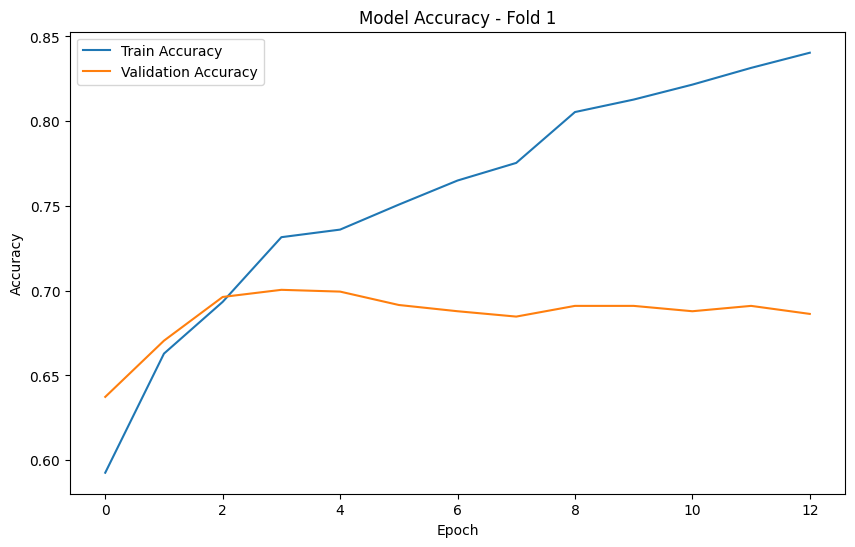

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-04-08 12:17:14.023756: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Fold 1 Results:
Accuracy: 0.6963
Balanced Accuracy: 0.6963
MCC: 0.3928
Sensitivity: 0.7105
Specificity: 0.6821

Fold 2/5
Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5645 - loss: 0.7612 - val_accuracy: 0.6321 - val_loss: 0.6224 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6788 - loss: 0.6058 - val_accuracy: 0.6842 - val_loss: 0.5853 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7071 - loss: 0.5668 - val_accuracy: 0.6705 - val_loss: 0.6094 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7310 - loss: 0.5355 - val_accuracy: 0.6832 - val_loss: 0.5967 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7509 - loss: 0.5091 - val_accuracy: 0.6858 - val_loss: 0.6130 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7659 - loss

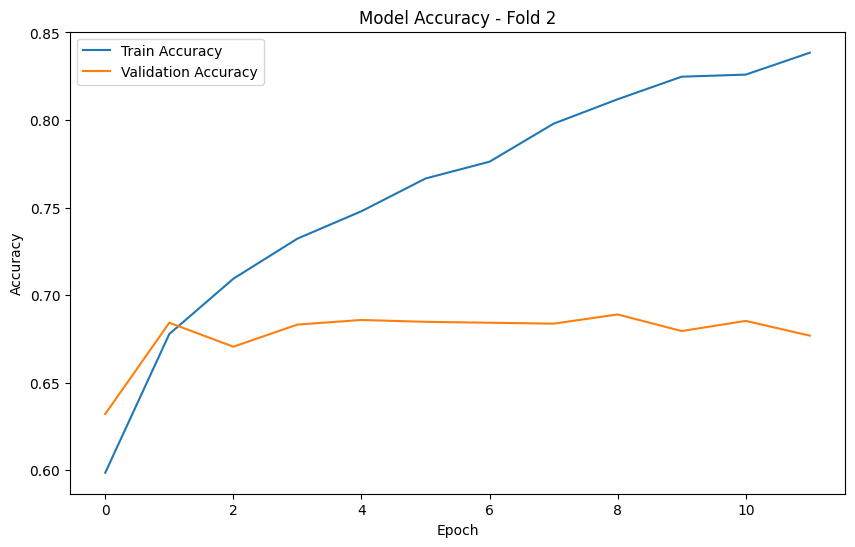

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-04-08 12:17:35.423568: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Fold 2 Results:
Accuracy: 0.6842
Balanced Accuracy: 0.6842
MCC: 0.3692
Sensitivity: 0.6526
Specificity: 0.7158

Fold 3/5
Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5814 - loss: 0.7706 - val_accuracy: 0.6595 - val_loss: 0.6191 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6773 - loss: 0.5963 - val_accuracy: 0.6737 - val_loss: 0.5945 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7078 - loss: 0.5635 - val_accuracy: 0.6589 - val_loss: 0.6106 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7361 - loss: 0.5336 - val_accuracy: 0.6695 - val_loss: 0.6183 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7470 - loss: 0.5076 - val_accuracy: 0.6747 - val_loss: 0.6217 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━

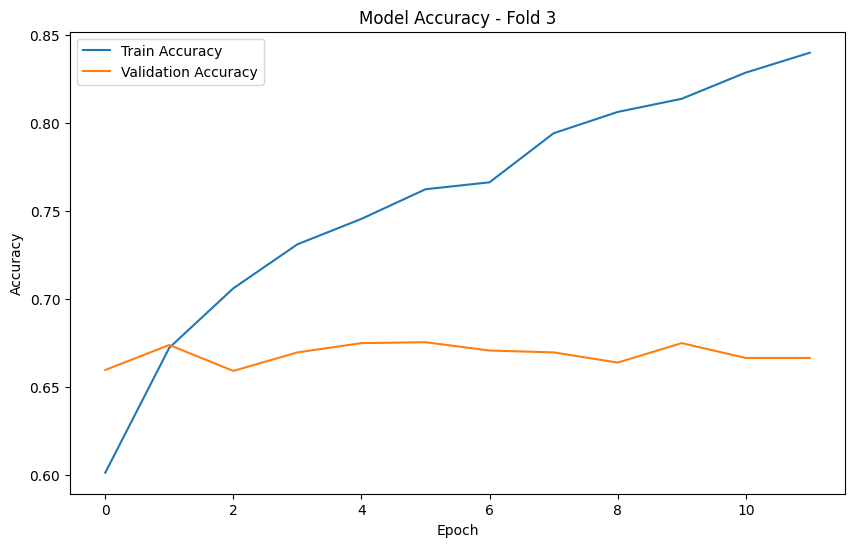

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-04-08 12:17:57.747621: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Fold 3 Results:
Accuracy: 0.6737
Balanced Accuracy: 0.6737
MCC: 0.3552
Sensitivity: 0.7779
Specificity: 0.5695

Fold 4/5
Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5651 - loss: 0.7854 - val_accuracy: 0.6726 - val_loss: 0.6071 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6580 - loss: 0.6313 - val_accuracy: 0.6689 - val_loss: 0.5899 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7037 - loss: 0.5678 - val_accuracy: 0.6689 - val_loss: 0.5932 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7244 - loss: 0.5332 - val_accuracy: 0.6758 - val_loss: 0.5981 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7475 - loss: 0.5126 - val_accuracy: 0.6747 - val_loss: 0.6244 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7698 - loss

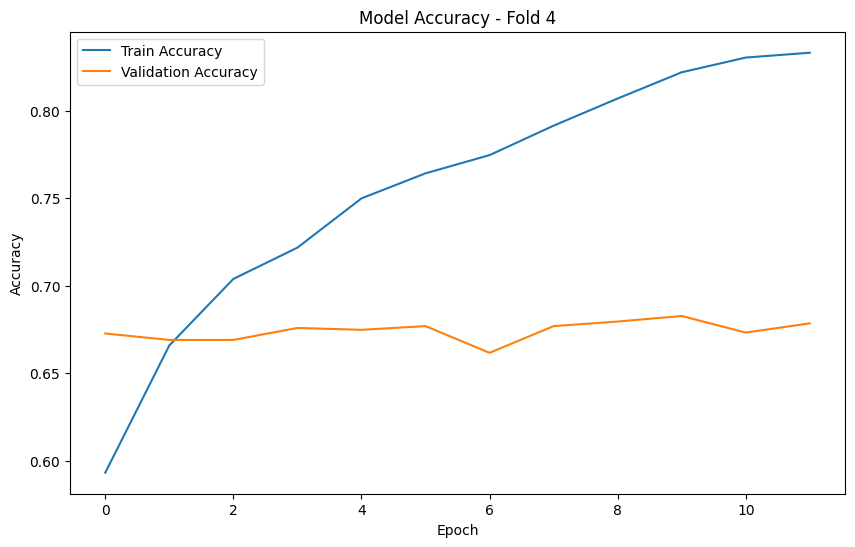

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-04-08 12:18:18.910725: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Fold 4 Results:
Accuracy: 0.6689
Balanced Accuracy: 0.6689
MCC: 0.3379
Sensitivity: 0.6758
Specificity: 0.6621

Fold 5/5
Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5883 - loss: 0.7639 - val_accuracy: 0.6695 - val_loss: 0.6149 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6787 - loss: 0.5944 - val_accuracy: 0.6784 - val_loss: 0.6056 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7120 - loss: 0.5640 - val_accuracy: 0.6816 - val_loss: 0.6028 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7408 - loss: 0.5258 - val_accuracy: 0.6800 - val_loss: 0.6000 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7450 - loss: 0.5095 - val_accuracy: 0.6884 - val_loss: 0.6175 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━

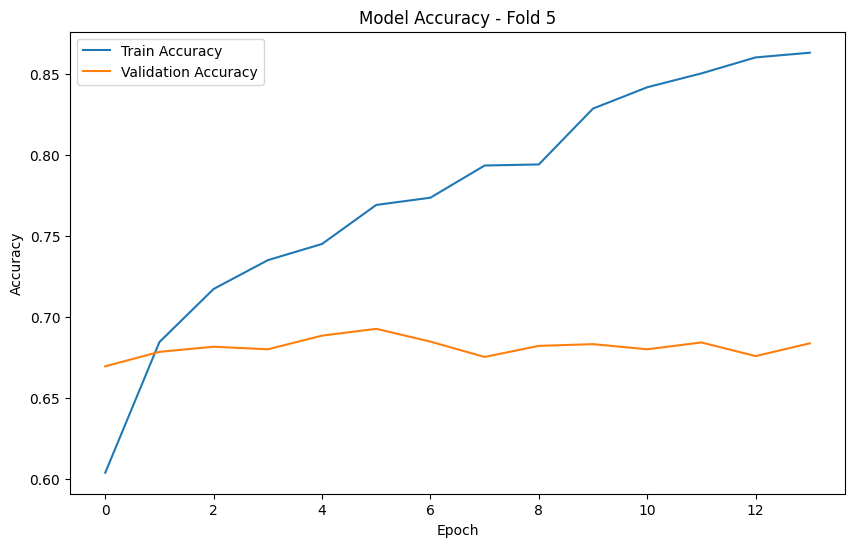

36/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

2025-04-08 12:18:44.539448: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 5 Results:
Accuracy: 0.6800
Balanced Accuracy: 0.6800
MCC: 0.3631
Sensitivity: 0.7453
Specificity: 0.6147

Average Cross-validation Results:
ACC: 0.6806 ± 0.0094
BALANCED_ACC: 0.6806 ± 0.0094
MCC: 0.3636 ± 0.0180
SN: 0.7124 ± 0.0454
SP: 0.6488 ± 0.0514

Final Test Set Results:
Accuracy: 0.6781
Balanced Accuracy: 0.6880
MCC: 0.2115
Sensitivity: 0.6996
Specificity: 0.6763
Confusion Matrix:
[[2010  962]
 [  76  177]]


In [12]:
model, test_probs = train_and_evaluate_prot_t5_model()
